In [1]:
# https://www.tensorflow.org/tutorials/text/image_captioning
# https://www.kaggle.com/code/dschettler8845/bms-image-captioning-w-attention-train
# https://github.com/tensorflow/models/tree/master/research/attention_ocr
# https://github.com/vuducnghia/attention-ocr
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')
APPROACH_NAME = 'Injection'

# Check GPU working

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Data input pipeline

In [3]:
DATASET_DIR = r'../../Dataset/IHR-NomDB'
LABELS_PATH = r'../../Dataset/IHR-NomDB/labels.txt'
FONT_PATH = r'../../Dataset/NomNaTong-Regular.ttf'

## Load and remove records with rare characters

In [4]:
from loader import DataImporter
dataset = DataImporter(DATASET_DIR, LABELS_PATH, min_length=1).remove_rare_chars(1)
print(dataset)

Samples count (not include Latin letters, numbers, punctuations):
- Number of images found: 101533
- Number of labels found: 101533
- Number of unique characters: 13168
- Characters present: {'之': 8193, '以': 4931, '月': 4007, '人': 3927, '十': 3611, '年': 3381, '不': 3263, '帝': 2955, '二': 2722, '大': 2641, '有': 2634, '日': 2561, '為': 2548, '其': 2537, '公': 2476, '兵': 2469, '等': 2404, '固': 2381, '於': 2311, '如': 2252, '國': 2194, '時': 2171, '官': 2160, '太': 2153, '爲': 2142, '子': 2140, '一': 2136, '天': 2077, '王': 2061, '軍': 2052, '而': 2019, '三': 1981, '事': 1955, '吏': 1942, '明': 1910, '朱': 1880, '使': 1825, '阮': 1818, '至': 1808, '曰': 1791, '及': 1646, '者': 1638, '文': 1631, '㐌': 1617, '安': 1612, '臣': 1601, '所': 1600, '行': 1569, '埃': 1563, '黎': 1511, '麻': 1494, '上': 1485, '皇': 1469, '也': 1469, '士': 1462, '命': 1444, '民': 1424, '是': 1418, '中': 1409, '自': 1407, '𢚸': 1387, '四': 1354, '五': 1346, '生': 1333, '道': 1331, '爫': 1319, '下': 1293, '郡': 1249, '元': 1243, '山': 1214, '渃': 1201, '𠊛': 1192, '宗': 1174, '莫': 

## Data constants and input pipeline

In [5]:
HEIGHT, WIDTH = 432, 48
PADDING_CHAR = '[PAD]' 
START_CHAR = '[START]'
END_CHAR = '[END]' 

In [6]:
from loader import DataHandler
data_handler = DataHandler(
    dataset, 
    img_size = (HEIGHT, WIDTH), 
    padding_char = PADDING_CHAR,
    start_char = START_CHAR,
    end_char = END_CHAR
)

In [7]:
MAX_LENGTH = data_handler.max_length
START_TOKEN = data_handler.start_token
END_TOKEN = data_handler.end_token
VOCAB_SIZE = data_handler.char2num.vocab_size()
BATCH_SIZE = 32

## Visualize the data

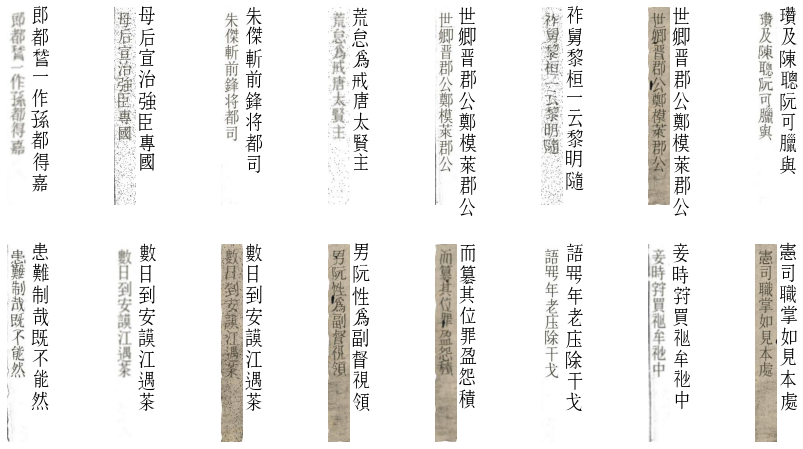

In [8]:
from visualizer import visualize_images_labels
visualize_images_labels(
    dataset.img_paths, 
    dataset.labels, 
    figsize = (15, 8),
    font_path = FONT_PATH, 
    text_x = WIDTH + 3
)

# Define model components

In [9]:
from tensorflow.keras.layers import (
    Input, Embedding, Dense, GRU, 
    Concatenate, GlobalAveragePooling1D, 
)
from layers import custom_cnn, get_imagenet_model, reshape_for_rnn
EMBEDDING_DIM = 512
UNITS = 1024

In [10]:
imagenet_model, imagenet_output_layer = None, None
# # Pick a model from https://keras.io/api/applications
# imagenet_model = get_imagenet_model('VGG16', (HEIGHT, WIDTH, 1))
# imagenet_output_layer = 'block4_pool'
# imagenet_model.summary(line_length=100)

## The encoder

In [11]:
def CNN_Encoder(imagenet_model=None, imagenet_output_layer=None, name='CNN_encoder'):
    if imagenet_model: # Use Imagenet model as CNN layers
        image_input = imagenet_model.input
        imagenet_model.layers[0]._name = 'image'
        features = imagenet_model.get_layer(imagenet_output_layer).output
    else: 
        image_input = Input(shape=(HEIGHT, WIDTH, 3), dtype='float32', name='image')
        conv_blocks_config = {
            'block1': {'num_conv': 1, 'filters':  64, 'pool_size': (2, 2)}, 
            'block2': {'num_conv': 1, 'filters': 128, 'pool_size': (2, 2)}, 
            'block3': {'num_conv': 2, 'filters': 256, 'pool_size': (2, 2)}, 
            'block4': {'num_conv': 2, 'filters': 512, 'pool_size': (2, 2)}, 
            
            # Last Conv blocks with 2x2 kernel but without no padding and pooling layer
            'block5': {'num_conv': 2, 'filters': 512, 'pool_size': None}, 
        }
        features = custom_cnn(conv_blocks_config, image_input)

    # Adding pixel coordinates to image features
    batch_size, h, w, _ = tf.shape(features)
    x, y = tf.meshgrid(tf.range(w), tf.range(h))
    w_loc = tf.one_hot(x, depth=w)
    h_loc = tf.one_hot(y, depth=h)
    loc = tf.concat([h_loc, w_loc], axis=2)
    loc = tf.tile(tf.expand_dims(loc, 0), multiples=[batch_size, 1, 1, 1])
    
    # (batch_size, height, width, num_features + coord)
    features = tf.concat([features, loc], axis=3) 
    features = reshape_for_rnn(features, dim_to_keep=1)
    return tf.keras.Model(inputs=image_input, outputs=features, name=name)

## The attention head

In [12]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units, name='BahdanauAttention', **kwargs):
        super(BahdanauAttention, self).__init__(name=name)
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, receptive_size, channels)
        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, receptive_size, units)
        attention_hidden_layer = self.W1(features) + self.W2(hidden_with_time_axis)
        attention_hidden_layer = tf.nn.tanh(attention_hidden_layer)

        # score shape == (batch_size, receptive_size, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, receptive_size, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, channels)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

## The decoder

In [13]:
def RNN_Decoder(enc_features_shape, name='RNN_Decoder'):
    token_input = Input(shape=(1,), name='new_token')
    features_input = Input(shape=enc_features_shape, name='encoder_features')
    pre_hidden_input = Input(shape=(UNITS,), name='previous_state')
    
    # Defining attention as a separate model
    attention = BahdanauAttention(UNITS)
    context_vector, attention_weights = attention(features_input, pre_hidden_input)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = Concatenate(axis=-1, name='context_and_embedding')([
        tf.expand_dims(context_vector, 1), 
        Embedding(VOCAB_SIZE, EMBEDDING_DIM)(token_input)
    ])
    
    # Passing the concatenated vector to the GRU
    rnn_output, state = GRU(
        units = UNITS, 
        return_state = True, 
        return_sequences = True, 
    )(x, initial_state=pre_hidden_input)

    x = Dense(UNITS, name='dense')(rnn_output)
    x = GlobalAveragePooling1D(name='average_pool')(x)
    y_pred = Dense(VOCAB_SIZE, name='prediction')(x)

    return tf.keras.Model(
        inputs = [token_input, features_input, pre_hidden_input], 
        outputs = [y_pred, state, attention_weights],
        name = name
    )

# Customize `Model.fit `

In [14]:
class ImageCaptioning(tf.keras.Model):
    def __init__(self, encoder, decoder, name='ImageCaptioning'):
        super(ImageCaptioning, self).__init__(name=name)
        self.encoder = encoder
        self.decoder = decoder
    
    def get_config(self):
        return {
            'encoder': CNN_Encoder(imagenet_model, imagenet_output_layer), 
            'decoder': RNN_Decoder(self.encoder.output_shape[1:])
        }
    
    @classmethod
    def from_config(cls, config):
        return cls(**config) # to clone model when using kfold training

## Custom training loop

In [15]:
@tf.function
def _compute_loss(self, batch):
    dec_input = tf.expand_dims([START_TOKEN] * BATCH_SIZE, 1) 
    hidden = tf.zeros((BATCH_SIZE, UNITS), tf.float32)

    batch_images, batch_tokens = batch
    features = self.encoder(batch_images)
    loss = tf.constant(0.0)

    for i in range(1, MAX_LENGTH):
        # Passing the features through the decoder
        y_pred, hidden, _ = self.decoder([dec_input, features, hidden])
        loss += self.loss(batch_tokens[:, i], y_pred) 
        
        # Use teacher forcing
        dec_input = tf.expand_dims(batch_tokens[:, i], 1) 
    
    # Update metrics
    predictions = self.predict(batch_images) 
    self.compiled_metrics.update_state(batch_tokens, predictions)
    
    display_result = {'loss': loss / MAX_LENGTH}
    display_result.update({m.name: m.result() for m in self.metrics})
    return loss, display_result

In [16]:
@tf.function
def train_step(self, batch):
    with tf.GradientTape() as tape:
        loss, display_result = self._compute_loss(batch)

    # Apply an optimization step
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    return display_result

@tf.function
def test_step(self, batch):
    _, display_result = self._compute_loss(batch)
    return display_result

## Custom prediction

In [17]:
@tf.function
def predict(self, batch_images, return_attention=False):
    batch_size = batch_images.shape[0]
    new_tokens = tf.fill([batch_size, 1], START_TOKEN)
    result_tokens, attentions = [new_tokens], []

    features = self.encoder(batch_images)
    hidden = tf.zeros((batch_size, UNITS), tf.float32)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)

    for _ in range(1, MAX_LENGTH):
        last_tokens = new_tokens
        y_pred, hidden, attention_weights = self.decoder([last_tokens, features, hidden])

        # Set the logits for all masked tokens to -inf, so they are never chosen
        y_pred = tf.where(data_handler.token_mask, float('-inf'), y_pred)
        new_tokens = tf.expand_dims(tf.argmax(y_pred, axis=-1), 1) 

        # If a sequence produces an `END_TOKEN`, set it `done` after that
        done = done | (last_tokens == END_TOKEN)

        # Once a sequence is done it only produces padding token
        new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)
        result_tokens.append(new_tokens)

        attentions.append(attention_weights)
        if tf.executing_eagerly() and tf.reduce_all(done): break

    result_tokens = tf.concat(result_tokens, axis=-1)
    if return_attention: return result_tokens, tf.concat(attentions, axis=-1)
    return result_tokens

## Summary

In [18]:
ImageCaptioning._compute_loss = _compute_loss
ImageCaptioning.train_step = train_step
ImageCaptioning.test_step = test_step
ImageCaptioning.predict = predict

In [19]:
encoder = CNN_Encoder(imagenet_model, imagenet_output_layer)
decoder = RNN_Decoder(encoder.output_shape[1:])
model = ImageCaptioning(encoder, decoder)

In [20]:
encoder.summary(line_length=120)
print()
decoder.summary(line_length=125)

Model: "CNN_encoder"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 image (InputLayer)                    [(None, 432, 48, 3)]       0             []                                      
                                                                                                                        
 block1_conv1 (Conv2D)                 (None, 432, 48, 64)        1792          ['image[0][0]']                         
                                                                                                                        
 block1_bn1 (BatchNormalization)       (None, 432, 48, 64)        256           ['block1_conv1[0][0]']                  
                                                                                                                        
 block1_rel

                                                                                                                        
 tf.range (TFOpLambda)                 (1,)                       0             ['tf.__operators__.getitem_2[0][0]']    
                                                                                                                        
 tf.range_1 (TFOpLambda)               (25,)                      0             ['tf.__operators__.getitem_1[0][0]']    
                                                                                                                        
 tf.meshgrid (TFOpLambda)              [(25, 1),                  0             ['tf.range[0][0]',                      
                                        (25, 1)]                                 'tf.range_1[0][0]']                    
                                                                                                                        
 tf.one_hot_1 (TFOpLambda)      

# Training

In [21]:
train_idxs = list(range(int(dataset.size * 0.8)))
valid_idxs = list(range(train_idxs[-1] + 1, dataset.size))
print('Number of training samples:', len(train_idxs))
print('Number of validate samples:', len(valid_idxs))

Number of training samples: 81226
Number of validate samples: 20307


In [22]:
import random
random.seed(2022)
random.shuffle(train_idxs)
random.shuffle(valid_idxs)

In [23]:
# When run on a small RAM machine, you can set use_cache=False to 
# not run out of memory but it will slow down the training speed
train_tf_dataset = data_handler.prepare_tf_dataset(
    train_idxs, BATCH_SIZE, drop_remainder=True 
)
valid_tf_dataset = data_handler.prepare_tf_dataset(
    valid_idxs, BATCH_SIZE, drop_remainder=True
)

## Callbacks

In [24]:
from callbacks import EarlyStoppingWithStuck
from tensorflow.keras.callbacks import ReduceLROnPlateau
early_stopping_callback = EarlyStoppingWithStuck(patience=5)

# Reduce the learning rate once learning stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 2, # Reduce if no improvement after 2 epochs
    min_lr = 1e-6, # Lower bound on the learning rate 
    factor = 0.5, # => new_lr = lr * factor
    verbose = 1
)

## Train the IHR-NomDB dataset

In [25]:
from losses import MaskedLoss
from metrics import SequenceAccuracy, CharacterAccuracy, LevenshteinDistance
from tensorflow.keras.optimizers import Adam
LEARNING_RATE = 2e-4
EPOCHS = 100

In [26]:
model.compile(
    optimizer = Adam(LEARNING_RATE), 
    loss = MaskedLoss(), 
    metrics = [
        SequenceAccuracy(),
        CharacterAccuracy(),
        LevenshteinDistance(normalize=True, name='lev_distance')
    ]
)

In [27]:
%%time
history = model.fit(
    train_tf_dataset,
    validation_data = valid_tf_dataset,
    epochs = EPOCHS,
    callbacks = [reduce_lr_callback, early_stopping_callback],
    verbose = 1
).history

Epoch 1/100
2538/2538 [==============================] - 461s 166ms/step - loss: 4.4500 - seq_acc: 7.3877e-05 - char_acc: 0.1830 - lev_distance: 0.7491 - val_loss: 5.4473 - val_seq_acc: 0.0000e+00 - val_char_acc: 0.1284 - val_lev_distance: 0.8678 - lr: 2.0000e-04
Epoch 2/100
2538/2538 [==============================] - 408s 161ms/step - loss: 3.1784 - seq_acc: 0.0022 - char_acc: 0.2998 - lev_distance: 0.6832 - val_loss: 2.6815 - val_seq_acc: 0.0013 - val_char_acc: 0.3948 - val_lev_distance: 0.5938 - lr: 2.0000e-04
Epoch 3/100
2538/2538 [==============================] - 408s 161ms/step - loss: 1.2315 - seq_acc: 0.0827 - char_acc: 0.6336 - lev_distance: 0.3596 - val_loss: 1.2869 - val_seq_acc: 0.0628 - val_char_acc: 0.6991 - val_lev_distance: 0.2930 - lr: 2.0000e-04
Epoch 4/100
2538/2538 [==============================] - 410s 161ms/step - loss: 0.5474 - seq_acc: 0.2880 - char_acc: 0.8199 - lev_distance: 0.1776 - val_loss: 1.1123 - val_seq_acc: 0.1257 - val_char_acc: 0.7393 - val_lev_di

## Save the training results

In [28]:
best_epoch = early_stopping_callback.best_epoch
print(f'- Loss on validation\t: {history["val_loss"][best_epoch]}')
print(f'- Sequence accuracy\t: {history["val_seq_acc"][best_epoch]}')
print(f'- Character accuracy\t: {history["val_char_acc"][best_epoch]}')
print(f'- Levenshtein distance\t: {history["val_lev_distance"][best_epoch]}')

- Loss on validation	: 0.33246350288391113
- Sequence accuracy	: 0.563042163848877
- Character accuracy	: 0.9386968016624451
- Levenshtein distance	: 0.05885287746787071


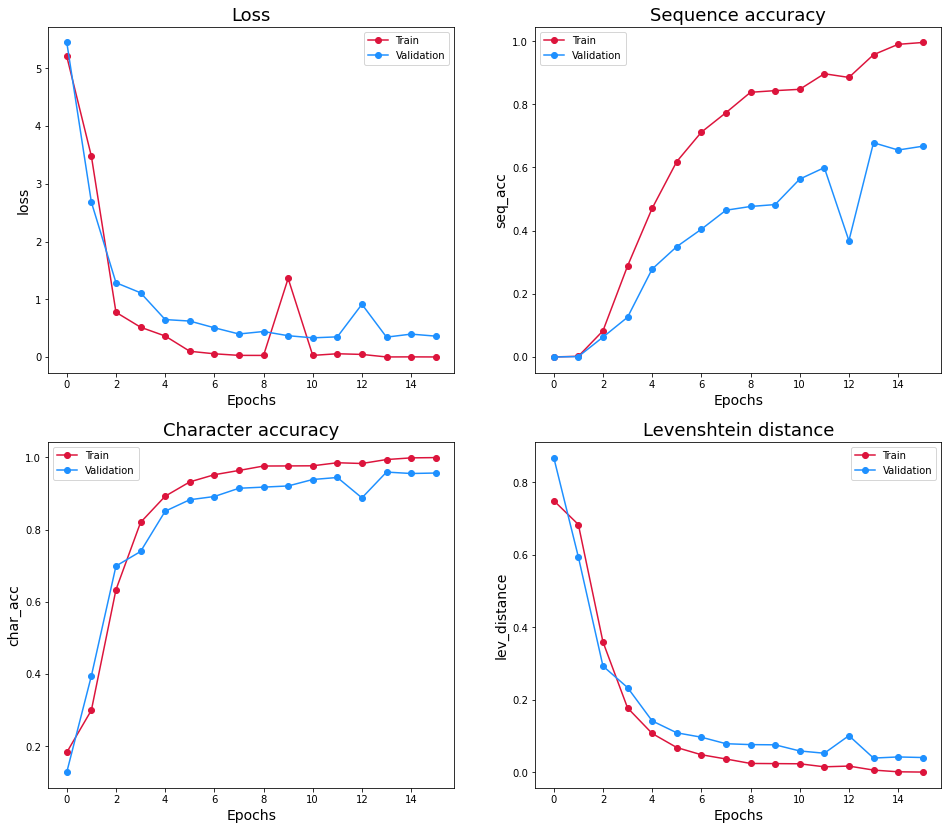

In [29]:
from visualizer import plot_training_results
plot_training_results(history, f'{APPROACH_NAME}.png')
model.encoder.save_weights(f'{APPROACH_NAME}_encoder.h5')
model.decoder.save_weights(f'{APPROACH_NAME}_decoder.h5')

# Inference

In [30]:
encoder = CNN_Encoder(imagenet_model, imagenet_output_layer)
decoder = RNN_Decoder(encoder.output_shape[1:])
encoder.load_weights(f'{APPROACH_NAME}_encoder.h5')
decoder.load_weights(f'{APPROACH_NAME}_decoder.h5')

In [32]:
reset_model = ImageCaptioning(encoder, decoder)
reset_model.compile(
    optimizer = Adam(LEARNING_RATE), 
    loss = MaskedLoss(), 
    metrics = [
        SequenceAccuracy(),
        CharacterAccuracy(),
        LevenshteinDistance(normalize=True, name='lev_distance')
    ]
)
reset_model.evaluate(valid_tf_dataset)

634/634 [==============================] - 53s 73ms/step - loss: 0.3624 - seq_acc: 0.5630 - char_acc: 0.9387 - lev_distance: 0.0589


[0.563042163848877,
 0.9386968016624451,
 0.05885287746787071,
 0.33246350288391113]

## On test dataset

Batch 01:
- True: {1: '二十日詔自今凣士人', 2: '及春秋髙而理明德', 3: '事其求封辝畧日國人徧', 4: '告立皇太子并賜綵幣', 5: '是皆揭標的於當時', 6: '因以上褚五十衣中褚', 7: '如各衙門應差捕得', 8: '脩政事有所舛紊人', 9: '帝親征何洞等四十九', 10: '下令各依圖次而退', 11: '咍𢶢𦷾渚底咹\U000f12d4𣈜𬧻', 12: '賭博之術不足以施', 13: '不能\U000f0c46\U000f0c47教士卒甚銳', 14: '命朝臣舉縣官聀有', 15: '至是令人排辨香花', 16: '及長容貌環偉聰明過', 17: '六月色旨禮部議定民', 18: '黎志兵部上書定功伯', 19: '冬十月詔傳位於皇太子', 20: '文武臣僚見者流涕', 21: '恩州阮啟使其子來行', 22: '長子昔以正位東宫', 23: '詔諸軍民不得服北人', 24: '上曰爾子幾人乎對', 25: '其村商賣怒廊百公', 26: '故合格黄袍者止八十', 27: '茂洽見有羙色心中悅', 28: '揮使掌衛事兼知豊祜堂', 29: '舍江至安决黔皷山駐營', 30: '後倚蘭夫人有娠生皇子', 31: '為以妾前年又𭁈宮女阮', 32: '號有厲致眾於朋來'}
- Pred: {1: '二十日詔自今凣士人', 2: '及春秋髙而理明德', 3: '事其求封辝畧日國人盧', 4: '告立皇太子并賜綵幣', 5: '是皆拘標的於當時', 6: '因以上褚五十衣中褚', 7: '如各衙門應差捕得', 8: '脩政事有所射紊人', 9: '帝親征何洞等四十九', 10: '下令各依圖政而退', 11: '咍𢶢𦷾渚底咹\U000f12d4𣈜𬧻', 12: '䐗𢘽之𧗱不足以庵', 13: '不能\U000f0c46\U000f0c47教士卒甚鋭', 14: '命朝臣舉縣官聀有', 15: '至是令人排辨香花', 16: '及長容豺𢷆偉聰明過', 17: '六月色旨禮部議定民', 18: '黎志兵部上書定功伯', 19: '冬十月詔傳位於皇太子', 20: '文武臣僚見者流洘', 21: '恩州阮啟使其子來行', 22: '長子昔以正位東宫', 23: '詔諸軍民不得服北人', 24: '上曰爾子幾人乎對', 

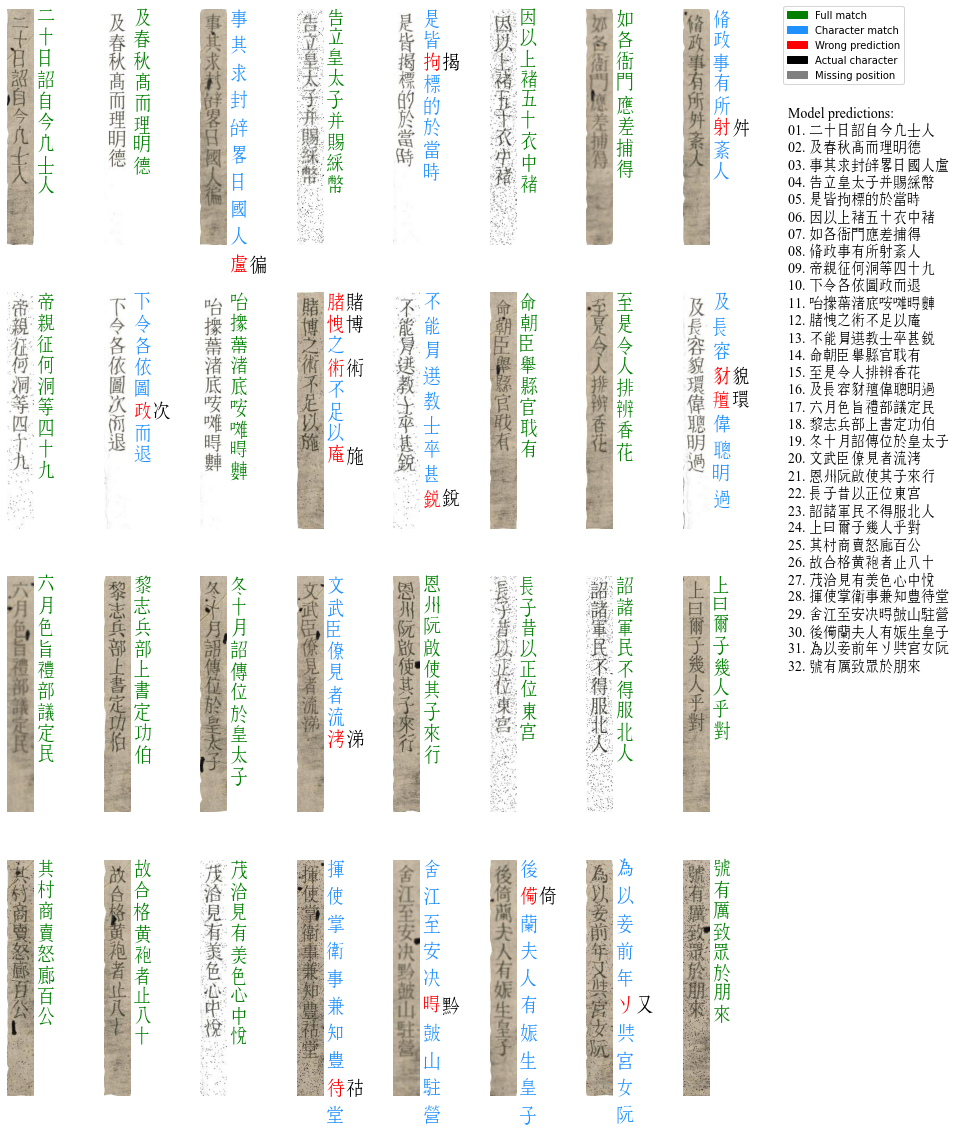

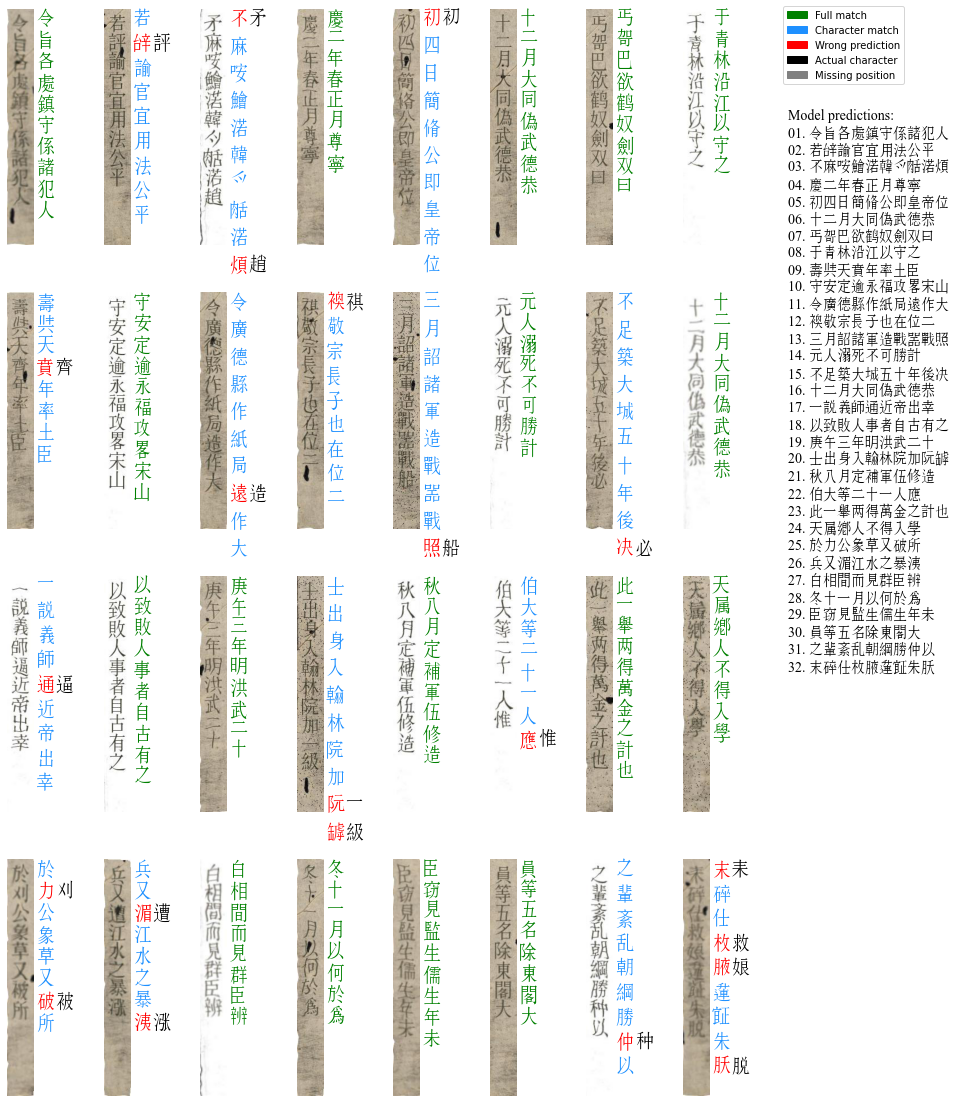

In [33]:
batch_results = []
for idx, (batch_images, batch_tokens) in enumerate(valid_tf_dataset.take(2)):
    idxs_in_batch = valid_idxs[idx * BATCH_SIZE: (idx + 1) * BATCH_SIZE]
    labels = data_handler.tokens2texts(batch_tokens)
    pred_tokens, attentions = reset_model.predict(batch_images, return_attention=True)
    pred_labels = data_handler.tokens2texts(pred_tokens)
    
    batch_results.append({'true': labels, 'pred': pred_labels, 'attentions': attentions})
    visualize_images_labels(
        img_paths = dataset.img_paths[idxs_in_batch], 
        labels = labels, 
        pred_labels = pred_labels,
        figsize = (14, 20),
        subplot_size = (4, 8),
        legend_loc = (3.8, 4.28),
        annotate_loc = (4, 1.8),
        font_path = FONT_PATH, 
        text_x = WIDTH + 5 # Position of actual label to plot
    )
    print(
        f'Batch {idx + 1:02d}:\n'
        f'- True: {dict(enumerate(labels, start=1))}\n'
        f'- Pred: {dict(enumerate(pred_labels, start=1))}\n'
    )

## On random image

In [34]:
random_path = '../囷𦝄苔惮󰞺𧍋𦬑囊.jpg'
random_label = '囷𦝄苔惮󰞺𧍋𦬑囊'
random_image = data_handler.process_image(random_path)
pred_tokens = reset_model.predict(tf.expand_dims(random_image, axis=0))
pred_labels = data_handler.tokens2texts(pred_tokens)

Predicted text: 翊𦝄苔㙩󰞺󰞺𧍋𦬑󰠲


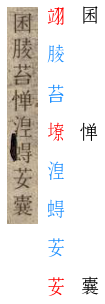

In [35]:
visualize_images_labels(
    img_paths = [random_path], 
    labels = [random_label], 
    pred_labels = pred_labels,
    figsize = (5, 4),
    subplot_size = (1, 1), 
    font_path = FONT_PATH, 
    text_x = 40 # Position to plot actual label
)
print('Predicted text:', ''.join(pred_labels))